# Getting Started with BrainMass

Welcome to BrainMass, a Python library for whole-brain computational modeling using differentiable neural mass models built on JAX.

## Learning Objectives

By the end of this tutorial, you will be able to:

- Understand what BrainMass is and its place in the BrainX ecosystem
- Install and configure BrainMass for your hardware (CPU/GPU/TPU)
- Run your first neural mass simulation
- Understand the basic workflow: model creation, initialization, simulation, visualization

## Prerequisites

- Basic Python programming knowledge
- Familiarity with NumPy arrays
- No prior knowledge of computational neuroscience required

## Background

### What is BrainMass?

**BrainMass** is a library for simulating brain dynamics using **neural mass models**. These models describe the collective activity of neuronal populations rather than individual neurons, making them computationally efficient for whole-brain simulations.

Key capabilities:
- **Brain dynamics simulation**: Model complex neural activity across brain regions
- **Neural signal fitting**: Fit model parameters to empirical data (MEG, EEG, fMRI)
- **Cognitive task training**: Train neural models to perform cognitive tasks
- **Differentiable optimization**: Leverage JAX for gradient-based parameter fitting

### The BrainX Ecosystem

BrainMass is part of the **BrainX ecosystem** for computational neuroscience:

| Library | Purpose |
|---------|--------|
| `brainstate` | State management and neural dynamics framework |
| `brainunit` | Physical units for neuroscience (ms, mV, Hz) |
| `braintools` | Visualization, metrics, and initialization utilities |
| `brainmass` | Neural mass models for whole-brain modeling |

### Neural Mass Models

Neural mass models represent the average activity of large neuronal populations. Instead of simulating millions of individual neurons, we model the *mean-field* dynamics of populations. This abstraction enables:

- Simulation of whole-brain dynamics with ~100 regions
- Direct comparison with macroscopic brain signals (EEG, MEG, fMRI)
- Efficient parameter optimization using gradient descent

## Installation

Install BrainMass using pip. Choose the appropriate variant for your hardware:

```bash
# CPU-only
pip install -U brainmass[cpu]

# NVIDIA GPU (CUDA 12)
pip install -U brainmass[cuda12]

# NVIDIA GPU (CUDA 13)
pip install -U brainmass[cuda13]

# Google TPU
pip install -U brainmass[tpu]
```

## Implementation

Let's walk through a complete simulation workflow step by step.

### Step 1: Setup and Imports

First, import the required libraries:

In [1]:
import brainstate  # State management and compilation
import braintools  # initialization and visualization
import brainmass  # Neural mass models
import brainunit as u  # Physical units
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting

# Check versions
print(f"BrainMass version: {brainmass.__version__}")

BrainMass version: 0.0.5


### Step 2: Configure the Simulation Environment

Set the simulation time step. BrainMass uses physical units from `brainunit`:

In [2]:
# Set time step to 0.1 milliseconds
dt = 0.1 * u.ms
brainstate.environ.set(dt=dt)

print(f"Time step: {dt}")

Time step: 0.1 * msecond


### Step 3: Create a Neural Mass Model

We'll use the **Hopf oscillator**, a simple model that captures oscillatory brain dynamics. The Hopf model describes how a neural population transitions between quiescent and oscillatory states.

Key parameters:
- `a`: Bifurcation parameter (a > 0 = oscillation, a < 0 = silent)
- `w`: Angular frequency of oscillation
- `beta`: Amplitude saturation

In [3]:
# Create a single Hopf oscillator node
node = brainmass.HopfStep(
    1,  # Number of nodes (brain regions)
    a=0.5,  # Bifurcation parameter (positive = oscillating)
    w=0.2,  # Angular frequency
    beta=1.0,  # Amplitude saturation
    init_x=braintools.init.Constant(0.5),
    init_y=braintools.init.Constant(0.5),
)

node

HopfStep(
  in_size=(1,),
  out_size=(1,),
  init_x=Constant(value=0.5),
  init_y=Constant(value=0.5),
  noise_x=None,
  noise_y=None,
  method=exp_euler,
  a=Const(
    fit=False,
    t=IdentityT(),
    reg=None,
    val=Array(0.5, dtype=float32)
  ),
  w=Const(
    fit=False,
    t=IdentityT(),
    reg=None,
    val=Array(0.2, dtype=float32)
  ),
  beta=Const(
    fit=False,
    t=IdentityT(),
    reg=None,
    val=Array(1., dtype=float32)
  )
)

### Step 4: Initialize Model States

Neural mass models have internal states (e.g., membrane potentials) that must be initialized before simulation:

In [4]:
# Initialize all state variables
node.init_all_states()

print(f"Initial x: {node.x.value}")
print(f"Initial y: {node.y.value}")

Initial x: [0.5]
Initial y: [0.5]


### Step 5: Run the Simulation

Define a step function and run the simulation using BrainState's efficient `for_loop`:

In [5]:
# Define the simulation step
def step_run(i):
    """Single simulation step."""
    node.update()  # Update model dynamics
    return node.x.value, node.y.value  # Return state values


# Simulate for 1000 ms (10,000 steps at dt=0.1ms)
n_steps = 10000
indices = np.arange(n_steps)

# Run simulation (compiled with JAX JIT for speed)
x_trace, y_trace = brainstate.transform.for_loop(step_run, indices)

print(f"Simulation complete!")
print(f"Output shape: {x_trace.shape} (time steps, nodes)")

Simulation complete!
Output shape: (10000, 1) (time steps, nodes)


### Step 6: Visualize Results

Plot the simulated neural activity:

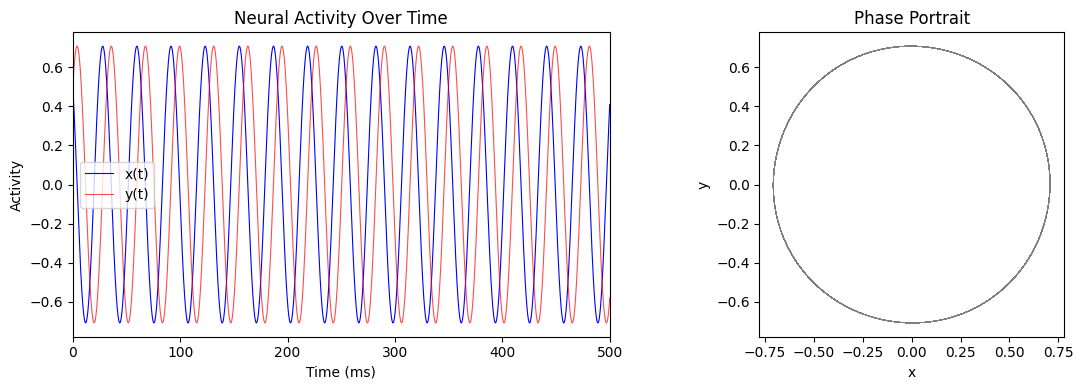

In [6]:
# Create time axis in milliseconds
t_ms = indices * brainstate.environ.get_dt()

# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Time series plot
axes[0].plot(t_ms, x_trace[:, 0], 'b-', label='x(t)', linewidth=0.8)
axes[0].plot(t_ms, y_trace[:, 0], 'r-', label='y(t)', linewidth=0.8, alpha=0.7)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Activity')
axes[0].set_title('Neural Activity Over Time')
axes[0].legend()
axes[0].set_xlim([0, 500])  # Show first 500 ms

# Phase portrait (x vs y)
axes[1].plot(x_trace[:, 0], y_trace[:, 0], 'k-', linewidth=0.5, alpha=0.5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Phase Portrait')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

## Exploring Model Behavior

The Hopf oscillator exhibits different behaviors depending on the bifurcation parameter `a`:

- **a < 0**: Stable fixed point (no oscillation)
- **a = 0**: Bifurcation point
- **a > 0**: Limit cycle oscillation

Let's visualize this:

In [7]:
@brainstate.transform.jit
def simulate_hope_model(a):
    model = brainmass.HopfStep(1, a=a, w=0.2, beta=1.0)
    model.init_all_states()

    # Set non-zero initial condition
    model.x.value = np.array([0.5])
    model.y.value = np.array([0.5])

    # Run simulation
    def step(i):
        model.update()
        return model.x.value

    return brainstate.transform.for_loop(step, indices)

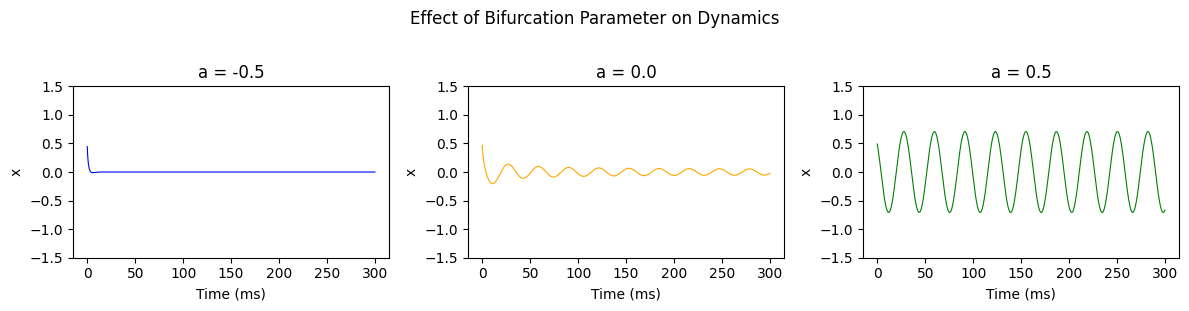

In [8]:
# Compare different values of 'a'
a_values = [-0.5, 0.0, 0.5]
colors = ['blue', 'orange', 'green']

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for idx, a_val in enumerate(a_values):
    x_trace = simulate_hope_model(a_val)

    # Plot
    axes[idx].plot(t_ms[:3000], x_trace[:3000, 0], color=colors[idx], linewidth=0.8)
    axes[idx].set_xlabel('Time (ms)')
    axes[idx].set_ylabel('x')
    axes[idx].set_title(f'a = {a_val}')
    axes[idx].set_ylim([-1.5, 1.5])

plt.suptitle('Effect of Bifurcation Parameter on Dynamics', y=1.02)
plt.tight_layout()
plt.show()

## Available Neural Mass Models

BrainMass provides a variety of neural mass models:

| Model | Description | Use Case |
|-------|-------------|----------|
| `HopfStep` | Hopf oscillator | Oscillatory dynamics, bifurcation studies |
| `FitzHughNagumoStep` | FitzHugh-Nagumo | Excitable systems, spiking dynamics |
| `WilsonCowanStep` | Wilson-Cowan | E/I balance, population dynamics |
| `JansenRitStep` | Jansen-Rit | EEG generation, alpha rhythms |
| `WongWangStep` | Wong-Wang | Decision making, working memory |
| `QIFStep` | Quadratic I&F | Mean-field spiking models |
| `KuramotoNetwork` | Kuramoto | Phase synchronization |
| `StuartLandauStep` | Stuart-Landau | Oscillations near bifurcation |
| `VanDerPolStep` | Van der Pol | Relaxation oscillations |

## Exercises

### Exercise 1: Modify Parameters

Try changing the Hopf model parameters:
1. What happens when you increase `w` (frequency)?
2. What happens when you increase `beta` (saturation)?

### Exercise 2: Use a Different Model

Replace `HopfStep` with `FitzHughNagumoStep` and observe the different dynamics.

*Hint*: The FitzHugh-Nagumo model has parameters `a`, `b`, `tau`, and `I_ext`.

### Exercise 3: Add Noise

Neural systems are inherently noisy. Add Ornstein-Uhlenbeck noise to the model:

```python
node = brainmass.HopfStep(
    1,
    a=0.5,
    w=0.2,
    beta=1.0,
    noise_x=brainmass.OUProcess(1, sigma=0.05, tau=5.0 * u.ms),
    noise_y=brainmass.OUProcess(1, sigma=0.05, tau=5.0 * u.ms),
)
```

How does noise affect the regularity of oscillations?

## References

- Deco, G., et al. (2017). "The dynamics of resting fluctuations in the brain." *Nature Reviews Neuroscience*.
- BrainMass Documentation: https://brainmass.readthedocs.io/
- BrainX Ecosystem: https://brainmodeling.readthedocs.io/